# Visualize the manually constructed dataset of mining areas and ground truth masks

In [3]:
import geopandas as gpd
import leafmap
from shapely.ops import unary_union
from shapely.geometry import Point, mapping, box, shape
import shapely
import json
import os
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

os.getcwd()
os.chdir("..")
root = os.path.dirname(os.getcwd())
# root = root + "/workspaces/mine-segmentation" # uncomment when running in Lightning Studios
root

'/Users/simonjasansky/programming/mine-segmentation'

In [4]:
raw_dataset = root + "/data/raw/mining_tiles_with_masks.gpkg"

post_dataset = root + "/data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg"

filtered_dataset = root + "/data/processed/mining_tiles_with_masks_and_bounding_boxes_filtered.gpkg"


In [14]:
# Load the data
data = gpd.read_file(raw_dataset, layer="tiles")
print(data.shape)
data.head()

(1517, 9)


,tile_id,s2_tile_id,source_dataset,preferred_dataset,minetype1,minetype2,comment,timestamp,geometry
0,2805,S2A_MSIL2A_20191017T004711_R102_T54LWM_2020100...,maus,maus,Surface,Industrial,,2024-07-04 10:04:22.755,"POLYGON ((141.8445 -12.50898, 141.84391 -12.32..."
1,1612,S2B_MSIL2A_20191007T061729_R034_T42UXD_2020100...,tang,tang,Surface,Industrial,,2024-07-04 10:05:26.560,"POLYGON ((72.06065 52.32091, 72.07342 52.50476..."
2,2352,S2B_MSIL2A_20190707T021609_R003_T50LMR_2020100...,both,tang,Surface,Industrial,,2024-07-04 10:06:29.655,"POLYGON ((117.00981 -9.0093, 117.00981 -8.8240..."
3,1167,S2A_MSIL2A_20190424T082611_R021_T33JYF_2020110...,both,tang,Surface,Industrial,,2024-07-04 10:07:19.452,"POLYGON ((18.02702 -31.33978, 18.02113 -31.155..."
4,1107,S2A_MSIL2A_20180827T101021_R022_T32SMD_2020102...,both,tang,Surface,Industrial,,2024-07-04 10:09:21.708,"POLYGON ((8.36212 34.32496, 8.36072 34.50964, ..."


In [15]:
# check distribution in minetype1 column
data["minetype1"].value_counts()

minetype1
Surface                     1247
Placer                       188
Brine & Evaporation Pond      58
Underground                   24
Name: count, dtype: int64

In [4]:
# check distribution in source_dataset column
data.source_dataset.value_counts()

source_dataset
both        724
maus        436
rejected    236
tang        121
Name: count, dtype: int64

In [5]:
# filter out only tiles with valid surface mines
data = data[data["minetype1"].isin(["Surface", "Placer"]) & data["source_dataset"].isin(["maus", "tang", "both"])]
print(data.shape)
data.source_dataset.value_counts()

(1210, 9)


source_dataset
both    697
maus    393
tang    120
Name: count, dtype: int64

In [6]:
# check how many tiles are overlapping with other tiles
data["overlaps"] = data["geometry"].apply(lambda x: data["geometry"].apply(lambda y: x.overlaps(y)).sum())
data["overlaps"].value_counts()

overlaps
0    825
1    232
2    106
3     35
4      4
6      3
7      3
5      2
Name: count, dtype: int64

<Axes: >

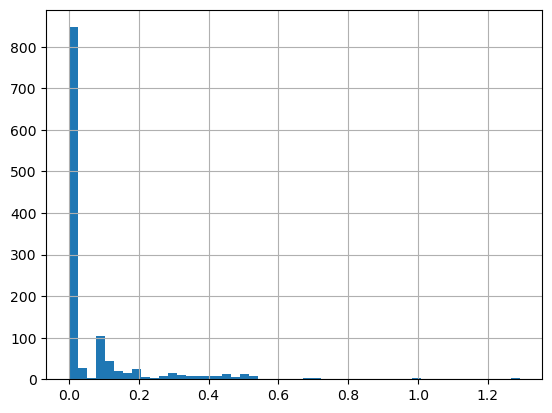

In [6]:
# calculate overlap percentage of each tile
data["overlap_percentage"] = data["geometry"].apply(lambda x: data["geometry"].apply(lambda y: x.intersection(y).area/x.area).sum() - 1)
data["overlap_percentage"].hist(bins=50)

In [7]:
# assign validation label to the tiles with overlap percentage less than 0.1
data["validation_eligible"] = data["overlap_percentage"].apply(lambda x: 1 if x < 0.1 else 0)
data["validation_eligible"].value_counts()

validation_eligible
1    969
0    241
Name: count, dtype: int64

In [8]:
# Create a Leaflet map
m = leafmap.Map()

style_eligible = {
    "stroke": True,
    "color": "green",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "green",
}

# change the color of the tiles with overlap percentage less than 0.1
m.add_gdf(data[data["validation_eligible"] == 1], layer_name="validation_eligible", style=style_eligible)

style_not_eligible = {
    "stroke": True,
    "color": "red",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "red",
}

# change the color of the tiles with overlap percentage more than 0.1
m.add_gdf(data[data["validation_eligible"] == 0], layer_name="validation_not_eligible", style=style_not_eligible)

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Assign overlapping tiles into groups


In [9]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon

# Assuming `data` is a GeoDataFrame with a 'geometry' column containing Polygon geometries

# Step 1: Create a graph
G = nx.Graph()

# Step 2: Add nodes
for idx, geom in data.iterrows():
    G.add_node(idx, geometry=geom.geometry)

# Step 3: Add edges for overlapping or touching geometries
for i, geom1 in data.iterrows():
    for j, geom2 in data.iterrows():
        if i != j and (geom1.geometry.overlaps(geom2.geometry) or geom1.geometry.touches(geom2.geometry)):
            G.add_edge(i, j)

# Step 4: Find connected components
connected_components = list(nx.connected_components(G))

# Step 5: Assign group IDs
group_id = 0
data['overlap_group'] = -1
for component in connected_components:
    for idx in component:
        data.at[idx, 'overlap_group'] = group_id
    group_id += 1

print(f"Number of connected components: {len(connected_components)}")

data.head()

Number of connected components: 971


,tile_id,s2_tile_id,source_dataset,preferred_dataset,minetype1,minetype2,comment,timestamp,geometry,overlaps,overlap_percentage,validation_eligible,overlap_group
0,2805,S2A_MSIL2A_20191017T004711_R102_T54LWM_2020100...,maus,maus,Surface,Industrial,,2024-07-04 10:04:22.755,"POLYGON ((141.8445 -12.50898, 141.84391 -12.32...",0,0.000000e+00,1,0
1,1612,S2B_MSIL2A_20191007T061729_R034_T42UXD_2020100...,tang,tang,Surface,Industrial,,2024-07-04 10:05:26.560,"POLYGON ((72.06065 52.32091, 72.07342 52.50476...",0,2.220446e-16,1,1
2,2352,S2B_MSIL2A_20190707T021609_R003_T50LMR_2020100...,both,tang,Surface,Industrial,,2024-07-04 10:06:29.655,"POLYGON ((117.00981 -9.0093, 117.00981 -8.8240...",0,1.000000e+00,0,2
3,1167,S2A_MSIL2A_20190424T082611_R021_T33JYF_2020110...,both,tang,Surface,Industrial,,2024-07-04 10:07:19.452,"POLYGON ((18.02702 -31.33978, 18.02113 -31.155...",1,1.000000e+00,0,3
4,1107,S2A_MSIL2A_20180827T101021_R022_T32SMD_2020102...,both,tang,Surface,Industrial,,2024-07-04 10:09:21.708,"POLYGON ((8.36212 34.32496, 8.36072 34.50964, ...",1,2.509085e-01,0,4


In [10]:
# Create a Leaflet map
m = leafmap.Map()
m.add_gdf(data)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Plot groups by color

In [17]:
import geopandas as gpd
import leafmap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Step 2: Define styles
def get_group_color(group_id, num_groups):
    cmap = plt.get_cmap('tab20')  # Use a colormap with enough distinct colors
    norm = mcolors.Normalize(vmin=0, vmax=num_groups - 1)
    return mcolors.to_hex(cmap(norm(group_id)))

# Get the number of unique groups
num_groups = data['overlap_group'].nunique()

# Step 3: Add tiles to the map
m = leafmap.Map()

for group_id in data['overlap_group'].unique():
    group_data = data[data['overlap_group'] == group_id]
    color = get_group_color(group_id, num_groups)
    style = {
        "stroke": True,
        "color": color,
        "weight": 2,
        "opacity": 1,
        "fill": True,
        "fillColor": color,
        "fillOpacity": 0.5,
    }
    m.add_gdf(group_data, layer_name=f"group_{group_id}", style=style)

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Visualize the global distribution of the tiles

In [ ]:
# Using Markers on leafmap
def plot_tiles_on_basemap(gdf):
    import folium

    m = folium.Map()

    # Iterate over the tiles and add markers to the map
    for _, row in gdf.iterrows():
        lat = row.geometry.centroid.y
        lon = row.geometry.centroid.x
        folium.Marker([lat, lon]).add_to(m)

    # Display the map
    return m

plot_tiles_on_basemap(data)

# Load processed dataset

In [7]:
# list layernames 
gpd.list_layers(post_dataset)

,name,geometry_type
0,tiles,Polygon
1,maus_polygons,MultiPolygon
2,tang_polygons,Unknown
3,maus_bboxes,MultiPolygon
4,tang_bboxes,MultiPolygon
5,preferred_polygons,MultiPolygon
6,preferred_bboxes,MultiPolygon


In [8]:
# load the processed dataset
tiles = gpd.read_file(post_dataset, layer="tiles")
maus_poly = gpd.read_file(post_dataset, layer="maus_polygons")
tang_poly = gpd.read_file(post_dataset, layer="tang_polygons")
preferred_poly = gpd.read_file(post_dataset, layer="preferred_polygons")
maus_bbox = gpd.read_file(post_dataset, layer="maus_bboxes")
tang_bbox = gpd.read_file(post_dataset, layer="tang_bboxes")
preferred_bbox = gpd.read_file(post_dataset, layer="preferred_bboxes")
tiles

,tile_id,s2_tile_id,source_dataset,preferred_dataset,minetype1,minetype2,comment,timestamp,geometry
0,2805,S2A_MSIL2A_20191017T004711_R102_T54LWM_2020100...,maus,maus,Surface,Industrial,,2024-07-04 10:04:22.755,"POLYGON ((141.8445 -12.50898, 141.84391 -12.32..."
1,1612,S2B_MSIL2A_20191007T061729_R034_T42UXD_2020100...,tang,tang,Surface,Industrial,,2024-07-04 10:05:26.560,"POLYGON ((72.06065 52.32091, 72.07342 52.50476..."
2,2352,S2B_MSIL2A_20190707T021609_R003_T50LMR_2020100...,both,tang,Surface,Industrial,,2024-07-04 10:06:29.655,"POLYGON ((117.00981 -9.0093, 117.00981 -8.8240..."
3,1167,S2A_MSIL2A_20190424T082611_R021_T33JYF_2020110...,both,tang,Surface,Industrial,,2024-07-04 10:07:19.452,"POLYGON ((18.02702 -31.33978, 18.02113 -31.155..."
4,1107,S2A_MSIL2A_20180827T101021_R022_T32SMD_2020102...,both,tang,Surface,Industrial,,2024-07-04 10:09:21.708,"POLYGON ((8.36212 34.32496, 8.36072 34.50964, ..."
...,...,...,...,...,...,...,...,...,...
1509,630,S2B_MSIL2A_20190921T143749_R096_T20NNN_2020100...,rejected,none,Placer,Artisanal,cloudy image,2024-08-27 16:29:40.578,"POLYGON ((-62.32414 6.65726, -62.32388 6.84251..."
1510,2006,S2B_MSIL2A_20190729T025549_R032_T48MZB_2020110...,rejected,none,Placer,Artisanal,cloudy image,2024-08-27 16:31:52.014,"POLYGON ((108.17512 -3.17611, 108.17561 -2.991..."
1511,861,S2B_MSIL2A_20190912T141049_R110_T21NXF_2020100...,rejected,none,Placer,Artisanal,inaccurate polygons,2024-08-27 16:35:28.938,"POLYGON ((-55.49122 4.6572, -55.49082 4.84241,..."
1512,1654,S2B_MSIL2A_20190330T050659_R019_T44QLJ_2020100...,both,tang,Surface,Industrial,,2024-08-27 16:38:46.515,"POLYGON ((79.34968 21.15852, 79.34762 21.34348..."


Construct one coherent dataset with the preferred mask

## Visualize the processed dataset

In [9]:
ROW = 6

m = leafmap.Map(center = (tiles.iloc[ROW:ROW+1].geometry.centroid.y.values[0], tiles.iloc[ROW:ROW+1].geometry.centroid.x.values[0]), zoom = 12)
# add satellite
m.add_basemap("SATELLITE")

style_tile = {
    "color": "orange",
    "fillColor": "orange",
    "fillOpacity": 0.0,
}

style_bbox = {
    "color": "green",
    "fillColor": "green",
    "fillOpacity": 0.0,
}

m.add_gdf(tiles.iloc[ROW:ROW+1], layer_name="tiles", style=style_tile)
m.add_gdf(preferred_poly.iloc[ROW:ROW+1], layer_name="masks")
m.add_gdf(preferred_bbox.iloc[ROW:ROW+1], layer_name="bboxes", style=style_bbox)
m

Map(center=[-32.24998637235755, 149.91666578859756], controls=(ZoomControl(options=['position', 'zoom_in_text'…

# Check the filtered dataset

In [5]:
gpd.list_layers(filtered_dataset)

,name,geometry_type
0,tiles,Polygon
1,polygons,MultiPolygon


In [6]:
# load the processed dataset
data = gpd.read_file(filtered_dataset, layer="tiles")
polygons = gpd.read_file(filtered_dataset, layer="polygons")
data

,tile_id,s2_tile_id,source_dataset,preferred_dataset,minetype1,minetype2,comment,timestamp,split,geometry
0,2,S2A_MSIL2A_20190429T210031_R100_T07WEM_2020110...,both,tang,Surface,Industrial,,2024-07-09 18:14:06.555,train,"POLYGON ((-139.21268 63.98899, -139.20086 64.1..."
1,5,S2A_MSIL2A_20190429T210031_R100_T07WEM_2020110...,tang,tang,Surface,Industrial,,2024-07-15 16:12:44.254,train,"POLYGON ((-139.04658 63.98876, -139.03366 64.1..."
2,6,S2A_MSIL2A_20181001T210301_R100_T07VEL_2020100...,tang,tang,Surface,Industrial,,2024-07-11 14:38:24.003,train,"POLYGON ((-139.04777 63.8221, -139.03496 64.00..."
3,9,S2A_MSIL2A_20190429T210031_R100_T07WEM_2020110...,both,tang,Surface,Industrial,,2024-07-23 11:27:17.430,train,"POLYGON ((-138.88048 63.98853, -138.86646 64.1..."
4,21,S2B_MSIL2A_20180920T204129_R014_T08WMS_2020100...,maus,maus,Surface,Industrial,,2024-07-26 12:34:32.941,train,"POLYGON ((-135.53826 63.99232, -135.54182 64.1..."
...,...,...,...,...,...,...,...,...,...,...
1202,2983,S2A_MSIL2A_20190712T003611_R002_T59WMQ_2020100...,both,maus,Surface,Industrial,,2024-08-12 12:14:36.405,val,"POLYGON ((169.82014 66.66, 169.81131 66.84368,..."
1203,2984,S2B_MSIL2A_20190412T223709_R072_T59GMK_2020100...,both,tang,Surface,Industrial,,2024-08-12 15:57:37.868,val,"POLYGON ((170.5468 -45.50942, 170.54827 -45.32..."
1204,2986,S2A_MSIL2A_20190407T223701_R072_T59GNP_2020100...,both,tang,Surface,Industrial,,2024-08-12 15:50:40.449,train,"POLYGON ((172.0413 -41.84116, 172.03833 -41.65..."
1205,2987,S2A_MSIL2A_20170801T003611_R002_T59WNS_2021021...,maus,maus,Placer,Industrial,,2024-08-27 15:19:38.901,train,"POLYGON ((172.33468 68.98962, 172.34591 69.173..."


In [7]:
# Provide unique value counts for categorical columns
categorical_columns = ['source_dataset', 'preferred_dataset', 'minetype1', 'minetype2', 'split']
for col in categorical_columns:
    print(f"Unique values in {col}:")
    print(data[col].value_counts())

Unique values in source_dataset:
source_dataset
both    695
maus    392
tang    120
Name: count, dtype: int64
Unique values in preferred_dataset:
preferred_dataset
tang    619
maus    588
Name: count, dtype: int64
Unique values in minetype1:
minetype1
Surface    1060
Placer      147
Name: count, dtype: int64
Unique values in minetype2:
minetype2
Industrial    975
Artisanal     232
Name: count, dtype: int64
Unique values in split:
split
train    838
val      249
test     120
Name: count, dtype: int64


In [8]:
# Create a Leaflet map
m = leafmap.Map()

style_train = {
    "stroke": True,
    "color": "green",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "green",
}

style_val = {
    "stroke": True,
    "color": "blue",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "blue",
}

style_test = {
    "stroke": True,
    "color": "red",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "red",
}

# Add train tiles to the map
m.add_gdf(data[data["split"] == "train"], layer_name="train", style=style_train)

# Add val tiles to the map
m.add_gdf(data[data["split"] == "val"], layer_name="val", style=style_val)

# Add test tiles to the map
m.add_gdf(data[data["split"] == "test"], layer_name="test", style=style_test)

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# Check the image masks and chips

In [10]:
file_index=10
chips_dir = "/data/processed/chips/train/chips"
labels_dir = "/data/processed/chips/train/labels"
files = os.listdir(root + chips_dir)
filename = root + chips_dir + "/" + files[file_index]

img = np.load(filename)
print(img.shape)
img

(3, 512, 512)


array([[[ 420.,  385.,  350., ...,  616.,  598.,  611.],
        [ 385.,  314.,  325., ...,  632.,  537.,  421.],
        [ 388.,  348.,  325., ...,  569.,  437.,  382.],
        ...,
        [1144., 1150., 1128., ...,  896.,  883.,  894.],
        [1020., 1013.,  955., ...,  866.,  874.,  869.],
        [ 886.,  884.,  830., ...,  855.,  821.,  844.]],

       [[ 720.,  707.,  640., ...,  910.,  911.,  858.],
        [ 697.,  673.,  657., ...,  845.,  821.,  724.],
        [ 641.,  614.,  617., ...,  821.,  714.,  645.],
        ...,
        [1210., 1244., 1238., ...,  684.,  675.,  678.],
        [1082., 1084., 1050., ...,  668.,  635.,  647.],
        [ 985.,  916.,  919., ...,  672.,  685.,  678.]],

       [[ 176.,  152.,  154., ...,  246.,  276.,  243.],
        [ 144.,   96.,  166., ...,  264.,  250.,  150.],
        [ 139.,  110.,  138., ...,  258.,  178.,  138.],
        ...,
        [ 877.,  920.,  895., ...,  498.,  523.,  522.],
        [ 789.,  766.,  724., ...,  497.,  51

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def plot_images_and_masks(root, seed=0):
    """
    Plot randomly selected images (numpy arrays) and their corresponding masks (numpy arrays).

    Parameters:
    - root (str): The root directory path
    - seed (int): The seed value for random number generation.

    Returns:
    None
    """

    chips_dir = root + "/data/processed/chips/train/chips"
    masks_dir = root + "/data/processed/chips/train/labels"

    files = os.listdir(chips_dir)
    fig, axs = plt.subplots(5, 2, figsize=(10, 25))

    # generate 5 random indices in the range of the number of files
    np.random.seed(seed)
    indices = list(np.random.choice(len(files), 5, replace=False))
    print(indices)

    for i, file_index in enumerate(indices):
        filename = os.path.join(chips_dir, files[file_index])
        img = np.load(filename)
        im2display = img.transpose((1, 2, 0))
        im2display = (im2display - im2display.min()) / (im2display.max() - im2display.min())
        im2display = np.clip(im2display, 0, 1)
        
        mask_filename = masks_dir + "/" + files[file_index].replace("_img", "_mask")
        mask = np.load(mask_filename).squeeze()
        
        resized_img = resize(im2display, (im2display.shape[0] // 2, im2display.shape[1] // 2))
        resized_mask = resize(mask, (mask.shape[0] // 2, mask.shape[1] // 2))

        # get date from the filename
        date = files[file_index].split("_")[3][:8]
        date = f"{date[:4]}-{date[4:6]}-{date[6:]}"

        axs[i, 0].imshow(resized_img)
        axs[i, 0].set_title(f"Image from {date}")
        
        axs[i, 1].imshow(resized_mask)
        axs[i, 1].set_title("Mask")
    
    plt.tight_layout()
    plt.show()

[29, 60, 31, 61, 23]


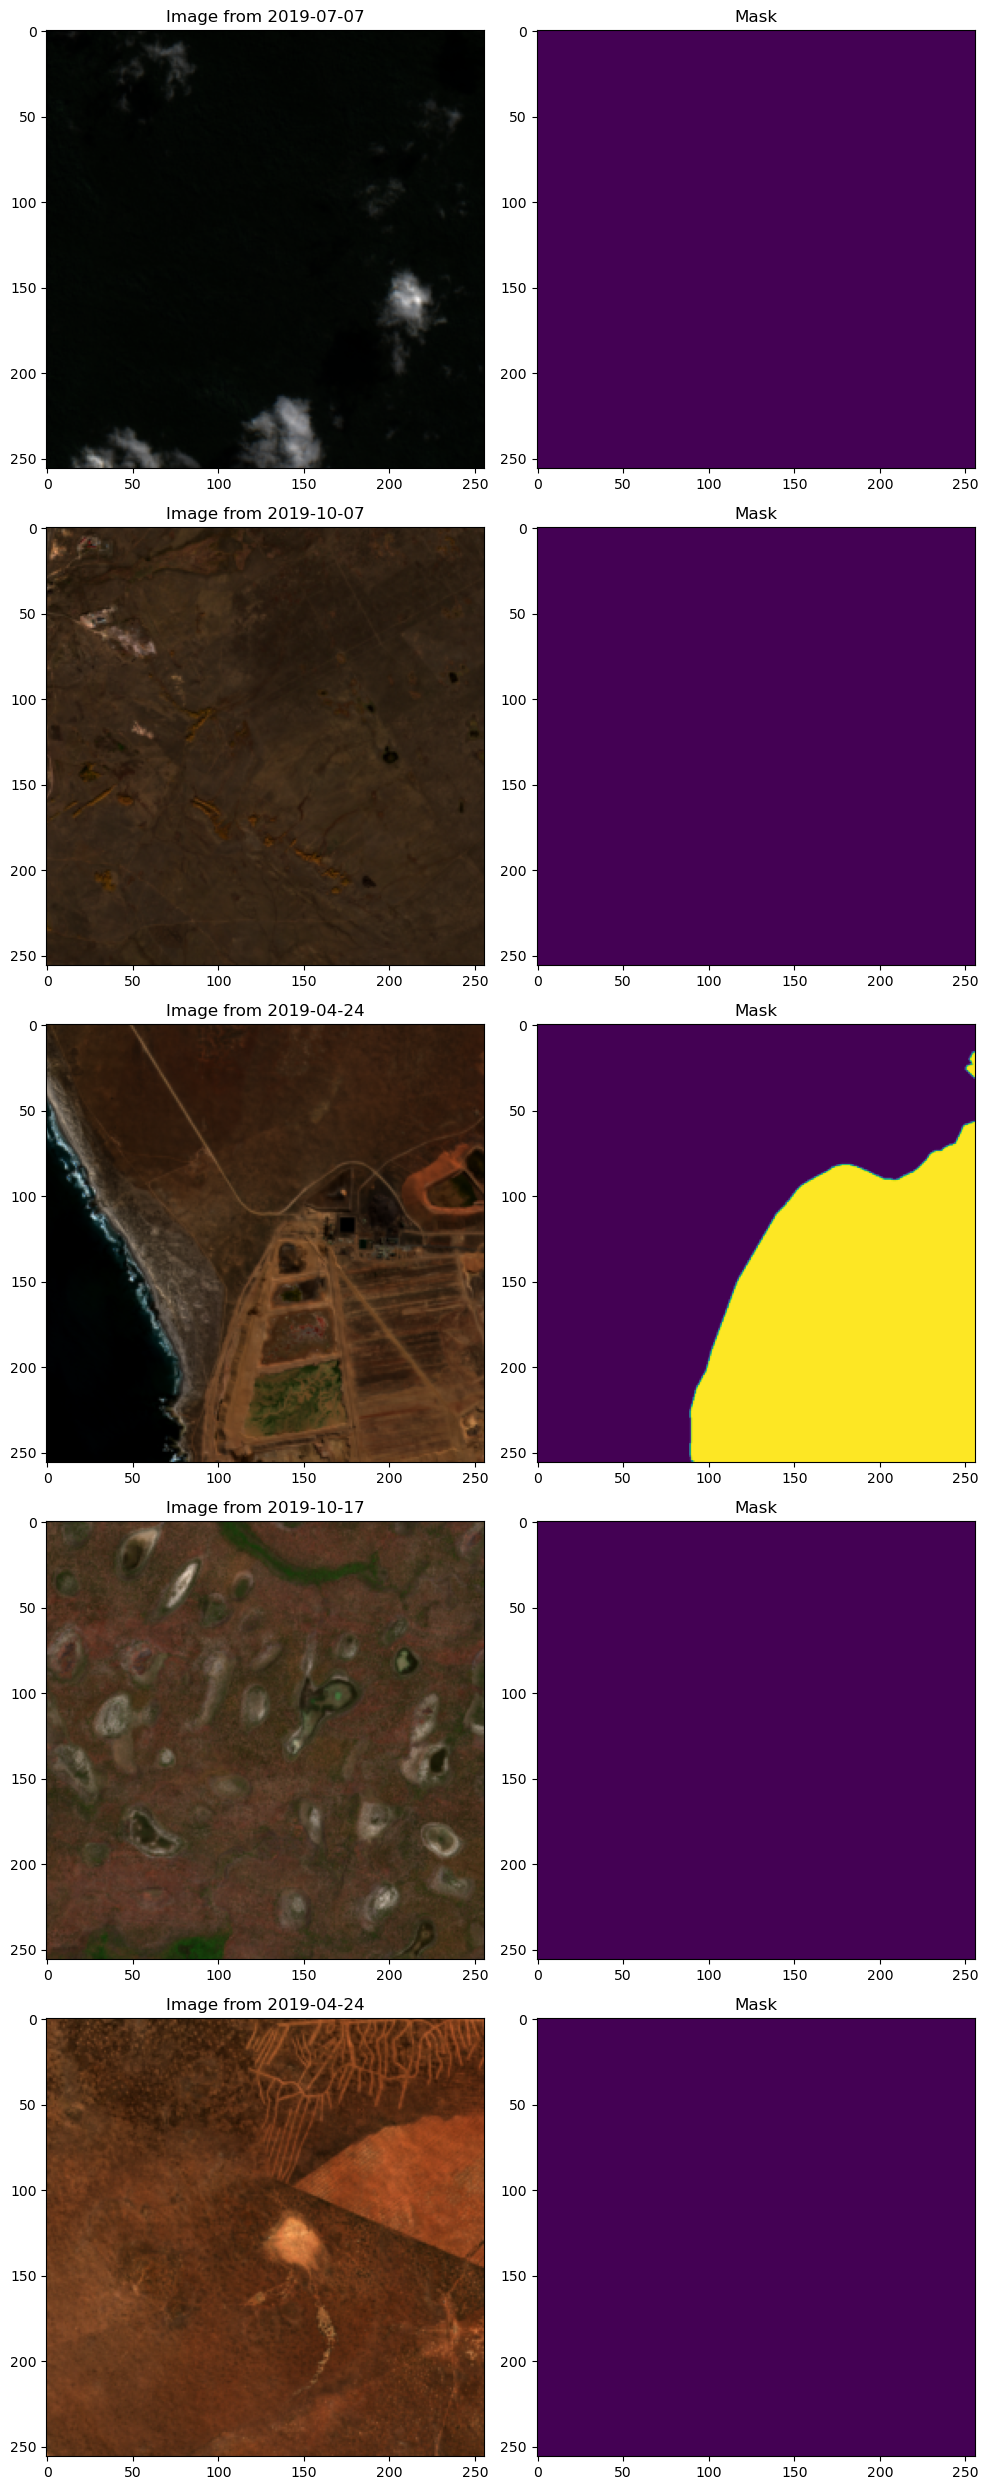

In [12]:
plot_images_and_masks(root, seed=5)